In [1]:
import numpy as np
import pandas as pd

import arviz as az
import corner

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfd = tfp.distributions
tfb = tfp.bijectors

2022-06-10 15:54:20.779223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-10 15:54:20.779238: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import bilby

from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

In [4]:
label = 'GW170817'
time_of_event = bilby.gw.utils.get_event_time(label)

In [5]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

In [6]:
H1_data = TimeSeries.fetch_open_data("H1", time_of_event, 
                                     time_of_event + 2,
                                     sample_rate=4096, cache=True)

L1_data = TimeSeries.fetch_open_data("L1", time_of_event, 
                                     time_of_event + 2,
                                     sample_rate=4096, cache=True)

In [7]:
H1.set_strain_data_from_gwpy_timeseries(H1_data)
L1.set_strain_data_from_gwpy_timeseries(L1_data)

In [8]:
interferometers = [H1, L1]

prior = {}
prior['mass_ratio'] = 0.977647
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066
prior['phase'] =  5.30408
prior['geocent_time'] = 1126259462.4146729

prior['chirp_mass'] = Uniform(
    name='chirp_mass',
    latex_label='$M$',
    minimum=25.0,
    maximum=35.0,
    unit='$M_{\\odot}$')

In [9]:
prior = {}
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066


In [10]:
prior_dict = bilby.core.prior.PriorDict(prior)

In [11]:
example = prior_dict.sample()

In [12]:
log_p = prior_dict.ln_prob(example)

In [13]:
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=100.)

waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

15:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [14]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers,
    waveform_generator,
    priors=prior)

In [15]:
w = waveform_generator.frequency_domain_strain(example)

/home/auratrik/Anaconda33/envs/igwn-py39-lw/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


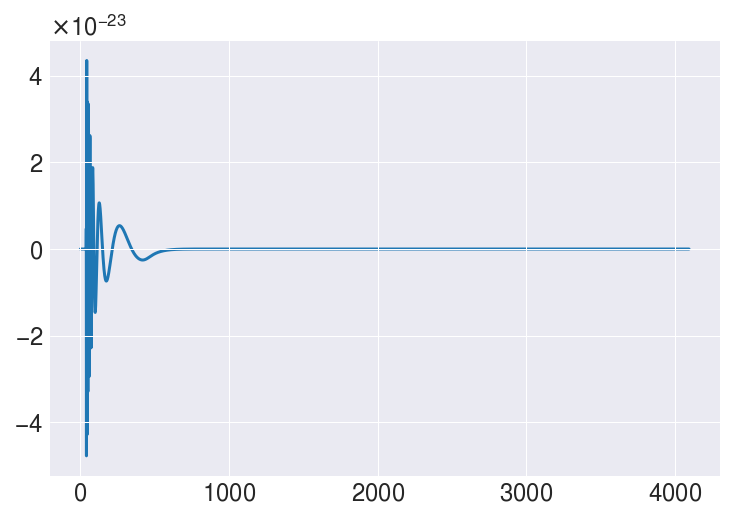

In [16]:
plt.plot(w['plus'])

In [17]:
likelihood.parameters.update(example)
log_l = likelihood.log_likelihood() 
log_post = log_p + log_l

15:54 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:54 bilby INFO    : Applying a tukey window with alpha=0.2, roll off=0.2
15:54 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:54 bilby INFO    : Applying a tukey window with alpha=0.2, roll off=0.2


In [18]:
print(log_post)

-9644175.166584753


2022-06-10 15:54:49.496946: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-10 15:54:49.496977: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (auratrik-Lenovo-Legion-5-15IMH05): /proc/driver/nvidia/version does not exist
2022-06-10 15:54:49.497532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


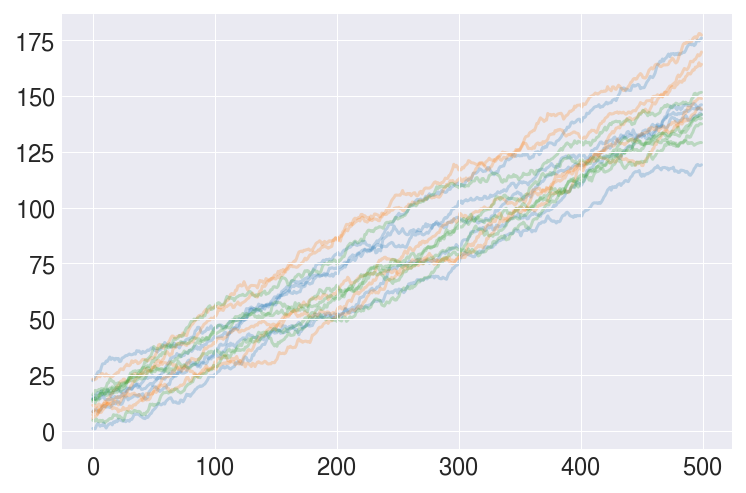

In [19]:
ndim = 3
nsample, nchain = 500, 5

def target_log_prob(log_post):
    #mean, var= tf.nn.moments(x, axes = [0, 1], keepdims = True)
    #return -tf.reduce_sum(((2*np.pi*var)**(-0.5))*np.exp((-(x - mean)**2)/(2*var)))
    return tf.convert_to_tensor(log_post)

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    num_leapfrog_steps=3,
    step_size=.25)

samples, is_accepted = tfp.mcmc.sample_chain(
    kernel=hmc_kernel,
    num_results=nsample,
    num_burnin_steps=50,
    trace_fn=lambda _, pkr: pkr.is_accepted,
    current_state=tf.zeros([nchain, ndim]))

for i in range(ndim):
  plt.plot(samples[..., i], alpha=.25, color=f'C{i}');


In [20]:
print(samples)

tf.Tensor(
[[[ 22.421972     5.465795    16.0785    ]
  [  1.0278544   23.13173     14.021806  ]
  [ 14.12551      7.1183324    4.651831  ]
  [  8.515108     8.556464    13.148812  ]
  [ 14.527367    11.446252    13.852289  ]]

 [[ 23.173054     6.3472433   16.90592   ]
  [  0.84845614  22.760551    14.477504  ]
  [ 14.597659     8.012183     4.7444654 ]
  [  9.183932     8.976276    13.481483  ]
  [ 15.697602    10.963137    14.591345  ]]

 [[ 24.37283      6.448449    18.09963   ]
  [  0.87919176  23.019537    14.062149  ]
  [ 13.979177     8.774626     4.3263354 ]
  [  9.299958     9.698496    12.376459  ]
  [ 15.996628    11.334329    14.761184  ]]

 ...

 [[141.93758    144.6244     140.52353   ]
  [144.73625    168.06424    141.44482   ]
  [174.74205    164.99849    129.11165   ]
  [118.9198     149.3796     137.31279   ]
  [145.24442    178.13535    151.44197   ]]

 [[142.44363    144.70717    139.81693   ]
  [144.1233     168.52296    141.31189   ]
  [175.32318    163.58702    

/home/auratrik/Anaconda33/envs/igwn-py39-lw/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (500) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


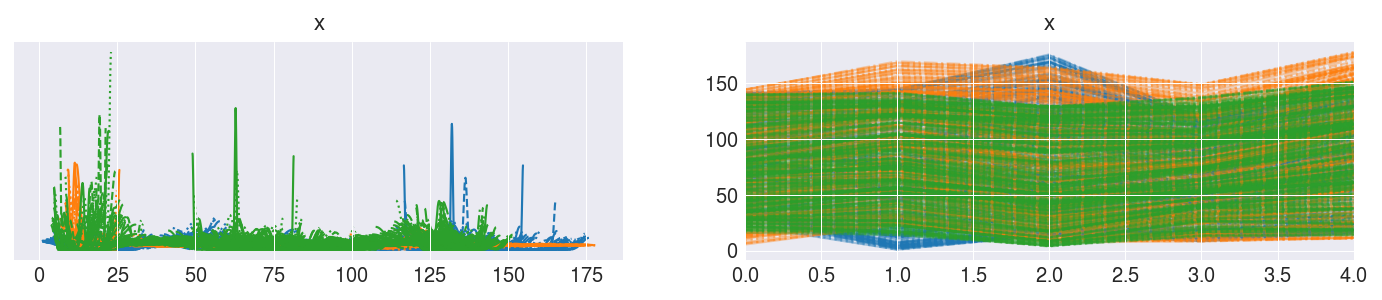

In [21]:
az.plot_trace(samples.numpy());

In [24]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [25]:
az.plot_kde(samples, quantiles=[0.025, 0.5, 0.925], rug=True);

#this is a numpy command so the error is coming

TypeError: Cannot interpret '<tf.Tensor: shape=(), dtype=float32, numpy=0.84845614>' as a data type

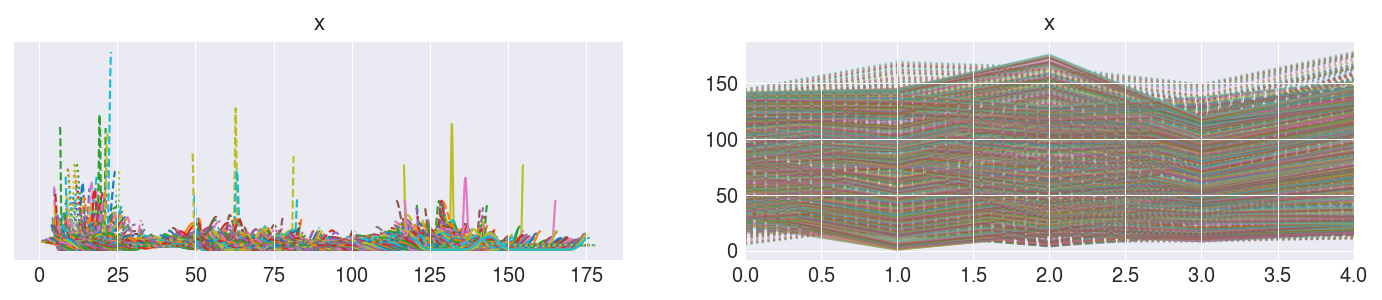

In [26]:
az.plot_trace(np.asarray(samples).T);

result_mc = bilby.run_sampler(log_l,
                              log_p,
                              sampler='dynesty',
                              outdir='short_mc_only',
                              walks=5,
                              nlive=50,
                              label=label)